# Lista 4

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Disciplina: Tópicos Especiais em Aprendizagem de Máquina / Tópicos Especiais em Lógica II

# Imports

In [11]:
import os
import numpy as np
import pandas as pd

from scipy.stats import norm, gamma
from scipy.stats import multivariate_normal as m_norm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.special import gamma as gamma_function

plt.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
sns.set_palette('deep')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Assignment 1 - PPCA

In [2]:
# READING DATA
data = np.genfromtxt('../data/mnist_5.csv', delimiter=',')
print('Shape:', data.shape)
X = data
X[:5,:]
X = X / 255

Shape: (6313, 784)


In [3]:
class PPCA():

    def __init__(self, L=2, random_state=32158):
        self.L = L
        self.rng = np.random.default_rng(random_state)

    def fit(self, X, n_iterations=20):
        self.X = X
        self.N, self.D = X.shape

        self.W = self.rng.uniform(0, 1, size=(self.D, self.L))
        self.mu = self.X.mean(axis=0).reshape(-1, 1)
        self.sigma = 0

        self.log_likelihood = []
        for iteration in range(n_iterations):
            #########################################
            ############## EXPECTATION ##############
            #########################################
            
            # Get M matrix (L x L)
            self.M = self.W.T @ self.W + self.sigma * np.eye(N=self.W.T.shape[0])
            self.M_inv = np.linalg.pinv(self.M)
            
            # Initiate arrays of expected values
            self.E_z = np.zeros(shape=(self.N, self.L, 1))
            self.E_z_zt = np.zeros(shape=(self.N, self.L, self.L))

            # Computing expected value for each latent variable
            for i in range(self.N):
                X_i = self.X[[i]].reshape(-1, 1)
                
                self.E_z[i] = self.M_inv @ self.W.T @ (X_i - self.mu)
                self.E_z_zt[i] = self.sigma * self.M_inv + self.E_z[i] @ self.E_z[i].T

            #########################################
            ############## MAXIMIZATION #############
            #########################################


            # Computing new W
            W_first_term = np.zeros(shape=(self.D, self.L))
            W_second_term = np.zeros_like(self.E_z_zt[0])
            for i in range(self.N):
                X_i = self.X[[i]].reshape(-1, 1)

                # Computing Sums
                W_first_term += ((X_i - self.mu) @ self.E_z[i].T)
                W_second_term += self.E_z_zt[i]

            self.W = W_first_term @ np.linalg.pinv(W_second_term)

            
            # Computing new sigma
            self.sigma = 0
            for i in range(self.N):
                X_i = self.X[[i]].reshape(-1, 1)
                
                sigma_first_term = np.linalg.norm(X_i - self.mu) ** 2
                sigma_second_term = -(2 * self.E_z[i].T @ self.W.T @ (X_i - self.mu))[0][0]
                sigma_third_term = np.trace(self.E_z_zt[i] @ self.W.T @ self.W)
                
                self.sigma += (sigma_first_term + sigma_second_term + sigma_third_term) 
            
            self.sigma = self.sigma / (self.N * self.D)

            # Storing log likelihood of actual iteration
            loglik = self.get_log_likelihood()
            self.log_likelihood.append(loglik)

    def get_log_likelihood(self):
        for i in range(self.N):
            X_i = self.X[[i]].reshape(-1, 1)

            t_1 = self.D / 2 * np.log(2*np.pi*self.sigma)
            t_2 = self.L / 2 * np.log(2*np.pi)
            t_3 = 0.5 * np.trace(self.E_z_zt[i])
            t_4 = 1/(2*self.sigma)*np.linalg.norm(X_i - self.mu) ** 2
            t_5 = self.E_z[i].T @ self.W.T @ (X_i - self.mu) / self.sigma
            t_6 = np.trace(self.E_z_zt[i] @ self.W.T @ self.W) / (2*self.sigma)

        loglik = -(t_1 + t_2 + t_3 + t_4 - t_5 + t_6)[0][0]
        return loglik

    def plot_log_likelihood(self, figsize=(10, 4)):
        %matplotlib inline

        plt.figure(figsize=figsize, facecolor='w')
        plt.title('Log Likelihood by Iteration')
        plt.plot(self.log_likelihood)
        plt.show()

    def plot_reconstruction_examples(self):
        fig_1, ax_1 = plt.subplots(5, 5, figsize=(10, 10), facecolor='white')
        fig_1.suptitle('Original Data', fontsize=18, fontweight='bold', y=0.95)
        fig_2, ax_2 = plt.subplots(5, 5, figsize=(10, 10), facecolor='white')
        fig_2.suptitle('Reconstructed Data', fontsize=18, fontweight='bold', y=0.95)
        for row in range(5):
            for col in range(5):
                chosen_index = self.rng.integers(X.shape[0])
                selected_X = self.X[[chosen_index]].reshape(-1, 1)
                data = selected_X * 255
                ax_1[row][col].imshow(data.reshape(28, 28), cmap='binary_r')
                ax_1[row][col].set_yticklabels([])
                ax_1[row][col].set_xticklabels([])
                
                #
                z = (self.M_inv @ self.W.T @ (selected_X - self.mu)).ravel()
                x_rec = (self.W @ z.reshape(-1, 1) + self.mu).ravel().reshape(28, 28)
                data = x_rec.reshape(28, 28) * 255
                ax_2[row][col].imshow(data, cmap='binary_r')
                ax_2[row][col].set_yticklabels([])
                ax_2[row][col].set_xticklabels([])
        
        plt.show()


    def plot_generated_data(self):
        # %matplotlib inline

        fig, ax = plt.subplots(5, 5, figsize=(10, 10), facecolor='white')
        fig.suptitle('Generated Data', fontsize=14, fontweight='bold', y=0.95)
        for row in range(5):
            for col in range(5):
                z = m_norm(mean=np.zeros(shape=(self.L)), cov=np.eye(self.L)).rvs()

                generative_distr = m_norm(
                    mean=(self.W @ z.reshape(-1, 1) + self.mu).ravel(), 
                    cov=self.sigma*np.eye(self.W.shape[0])
                )

                x_gen = generative_distr.rvs().reshape(28, 28)
                data = x_gen.reshape(28, 28) * 255
                
                ax[row][col].imshow(data, cmap='binary_r')
                ax[row][col].set_yticklabels([])
                ax[row][col].set_xticklabels([])

## L = 2



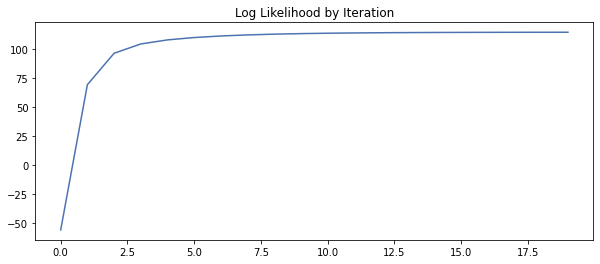

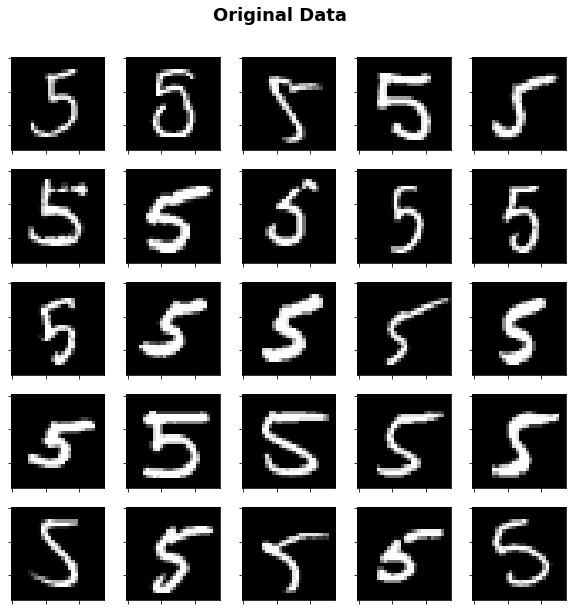

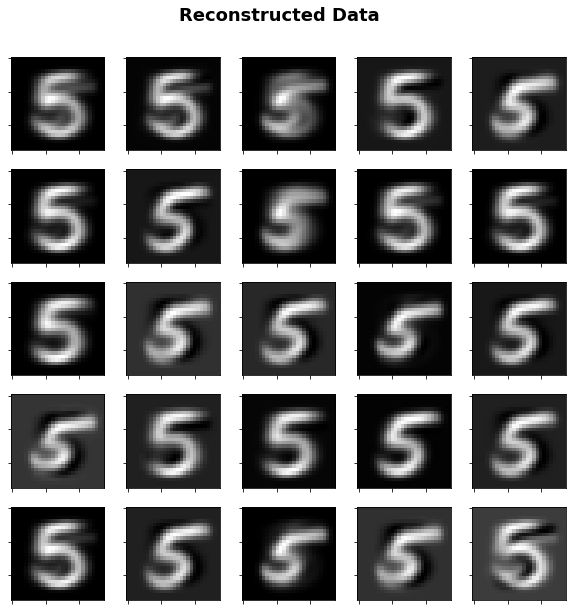

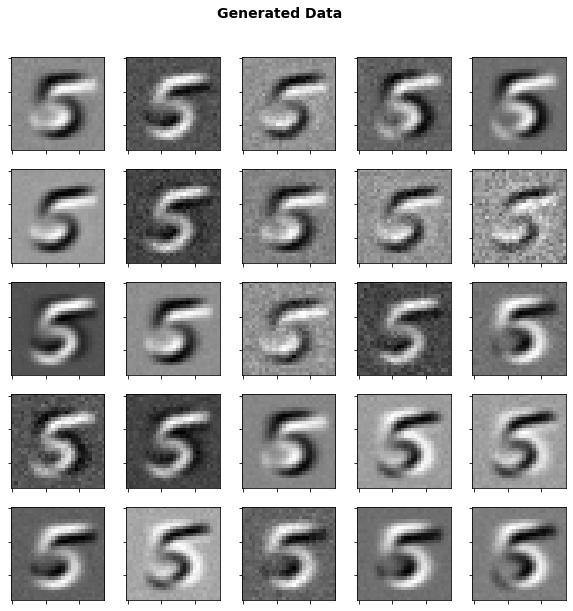

In [4]:
ppca = PPCA(L=2, random_state=3214)
ppca.fit(X, n_iterations=20)
ppca.plot_log_likelihood()
ppca.plot_reconstruction_examples()
ppca.plot_generated_data()

## L = 10

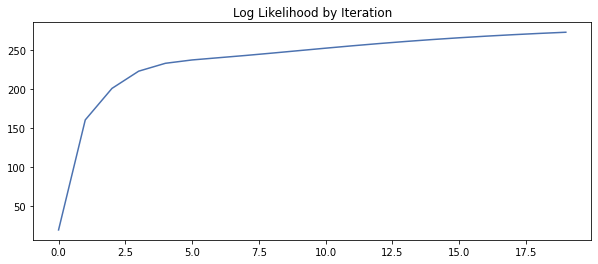

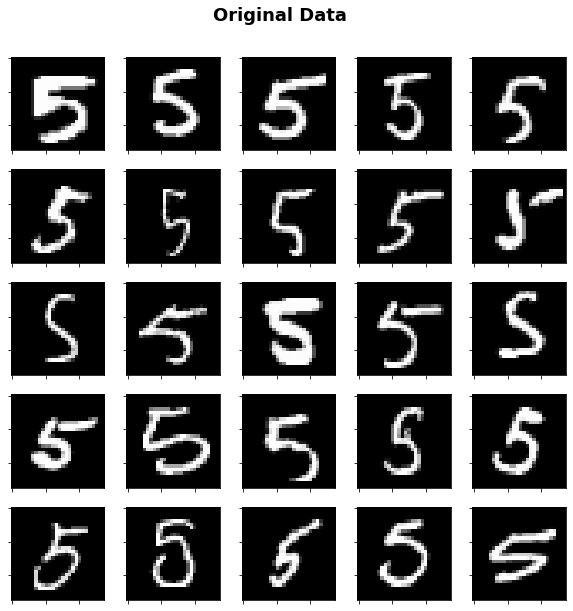

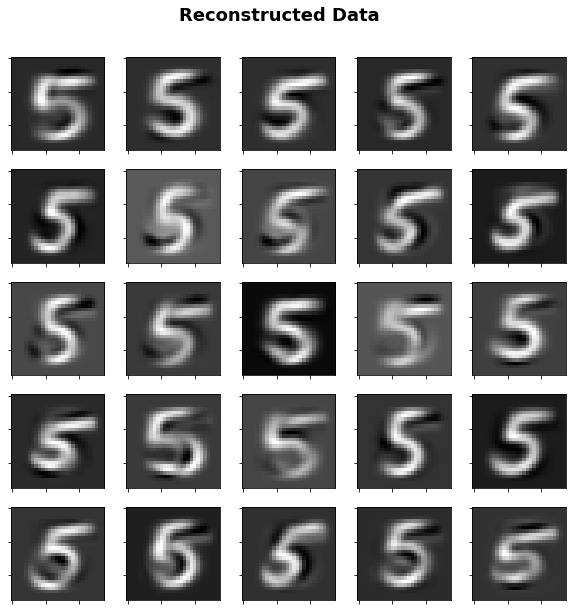

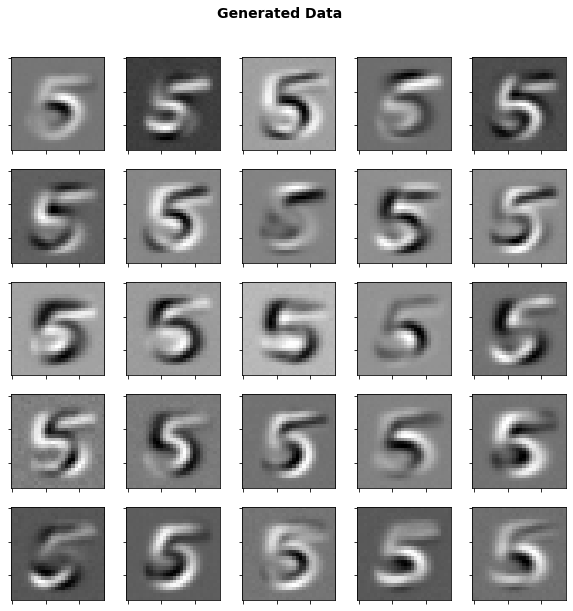

In [5]:
ppca = PPCA(L=10, random_state=656482)
ppca.fit(X, n_iterations=20)
ppca.plot_log_likelihood()
ppca.plot_reconstruction_examples()
ppca.plot_generated_data()

## L = 20

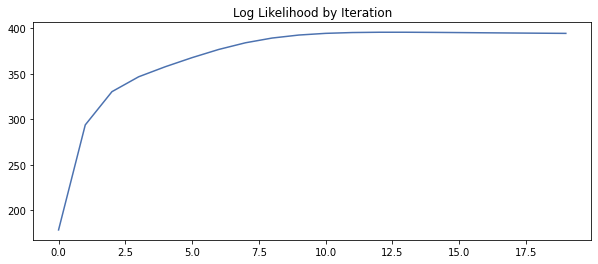

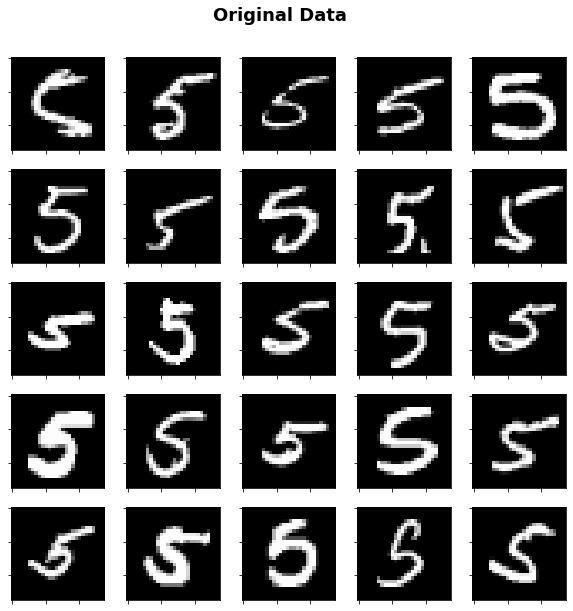

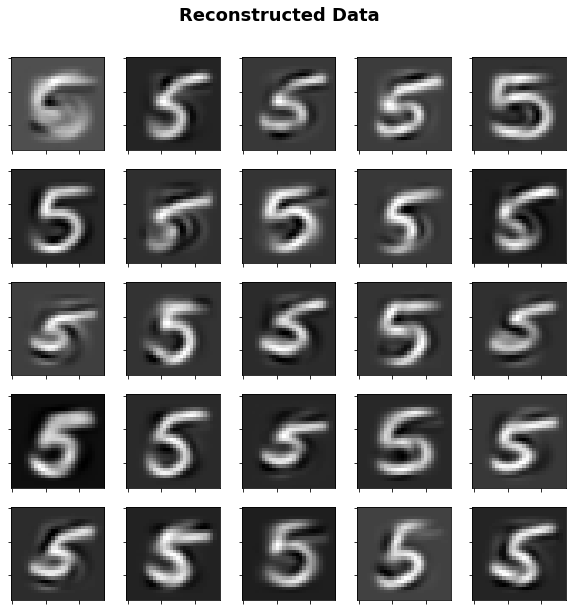

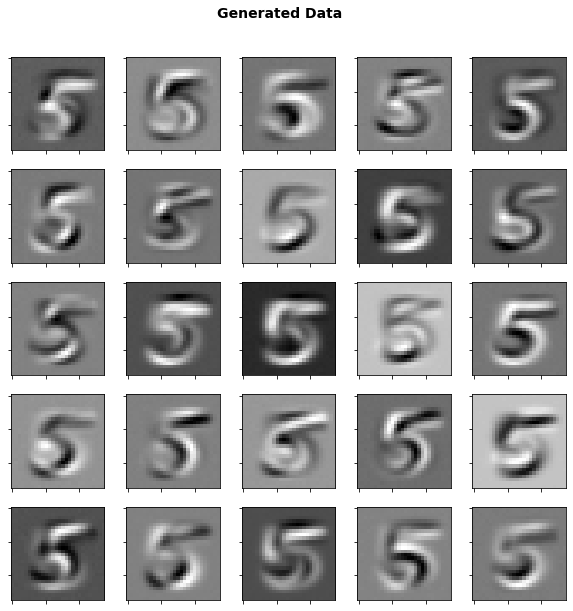

In [6]:
ppca = PPCA(L=20, random_state=3214)
ppca.fit(X, n_iterations=20)
ppca.plot_log_likelihood()
ppca.plot_reconstruction_examples()
ppca.plot_generated_data()

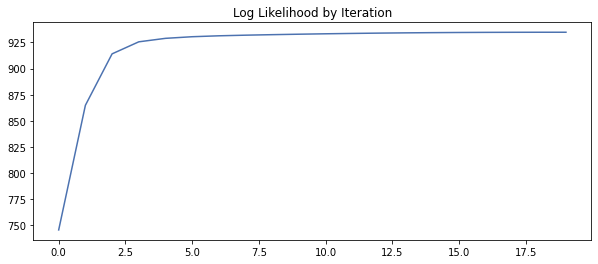

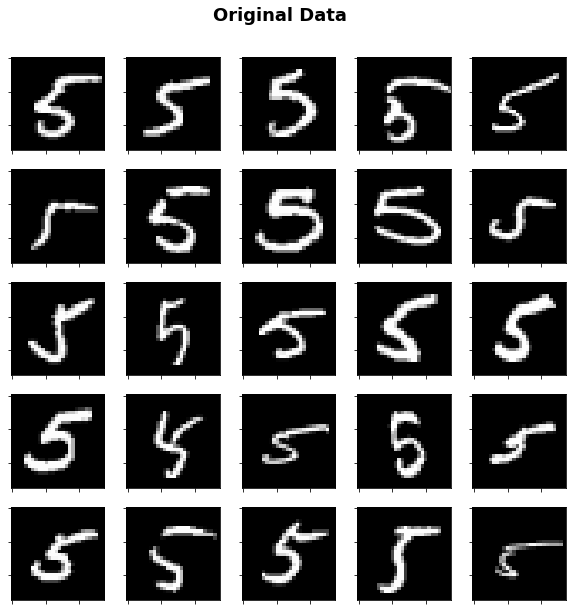

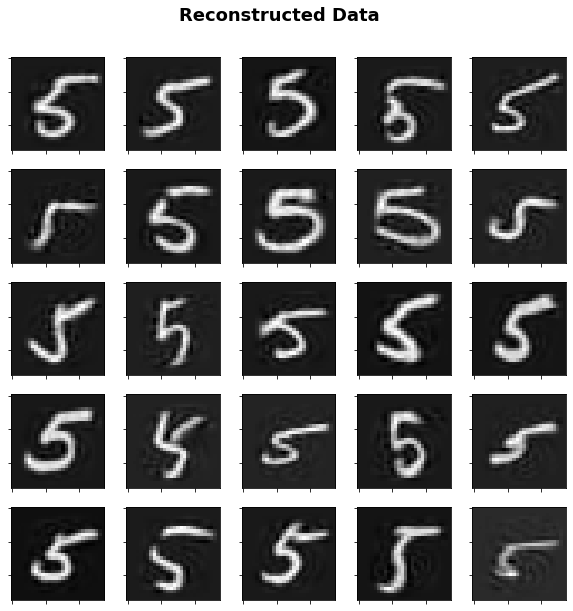

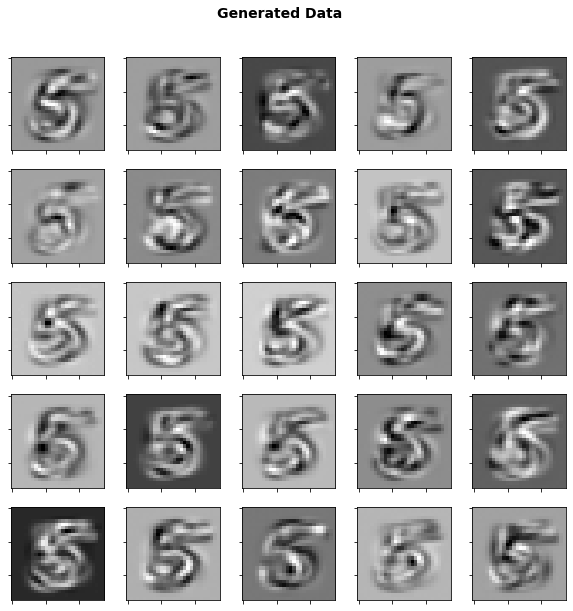

In [7]:
ppca = PPCA(L=128, random_state=3214)
ppca.fit(X, n_iterations=20)
ppca.plot_log_likelihood()
ppca.plot_reconstruction_examples()
ppca.plot_generated_data()

# Assignment 2 - Variational Inference

In [15]:
# READING DATA
data = np.genfromtxt('../data/gaussian_1d.csv', delimiter=',')
print('Shape:', data.shape)
data = data.reshape(-1, 1)
data[:5, :]

Shape: (500,)


array([[1.23234324],
       [2.70522973],
       [2.20009601],
       [0.93488879],
       [1.59086784]])

In [16]:
def ELBO(k, a, b):
    return 0.5*np.log(1/k) + np.log(gamma_function(a)) - a*np.log(b)


>>> Sample Size: 10


EXPECTED MU: 1.6635318570534805
EXPECTED TAU: 1.739539118133071 



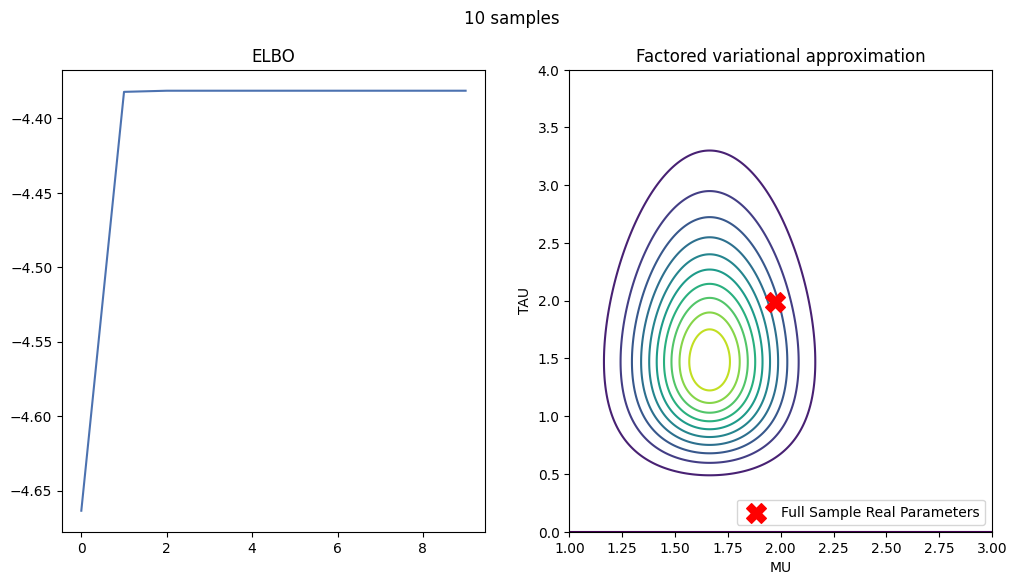


>>> Sample Size: 50


EXPECTED MU: 2.021525461665468
EXPECTED TAU: 1.8327722600015466 



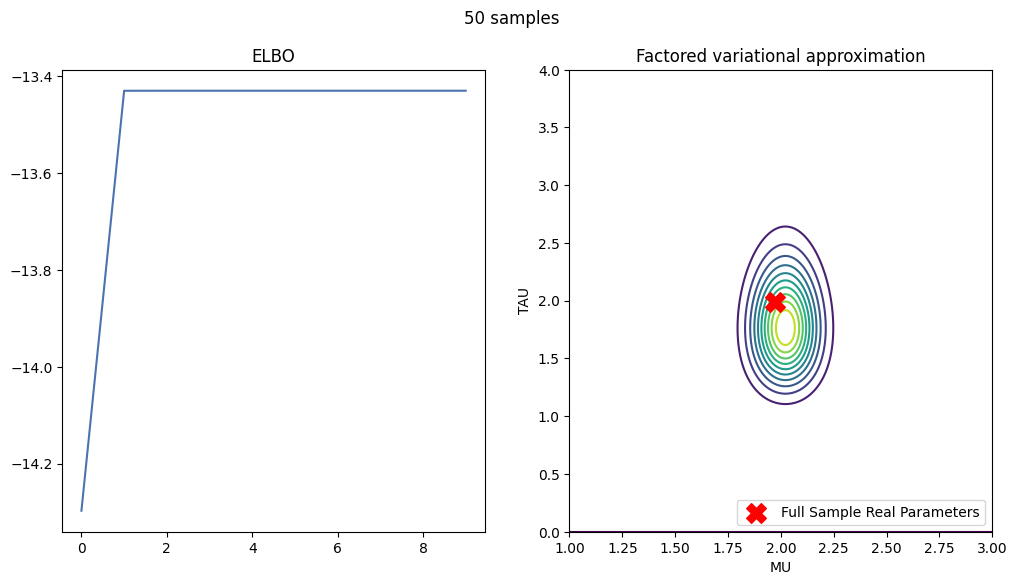


>>> Sample Size: 100


EXPECTED MU: 1.8866458035690432
EXPECTED TAU: 2.075508907540726 



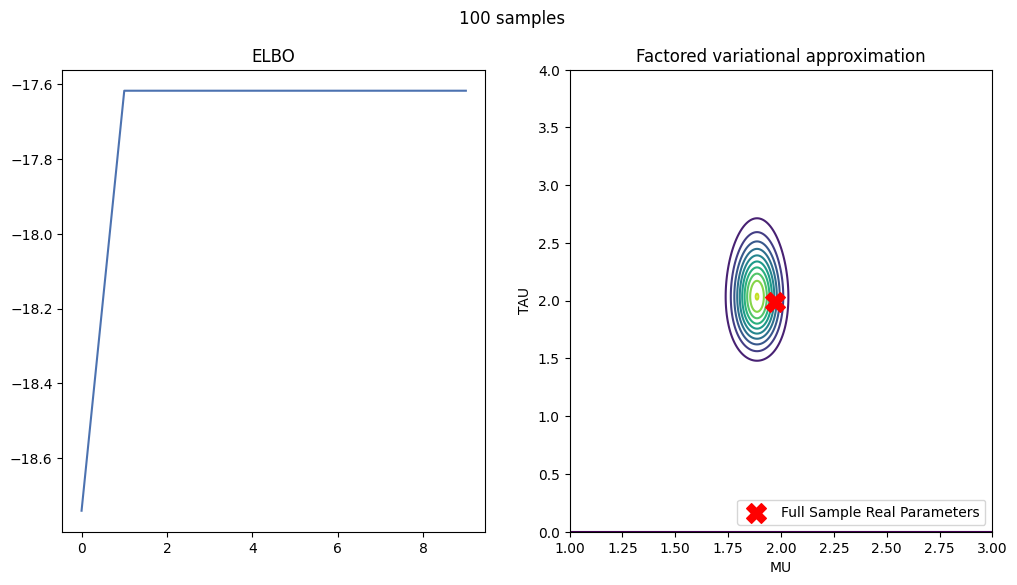


>>> Sample Size: 500


EXPECTED MU: 1.9687371100567022
EXPECTED TAU: 1.9496079147975363 



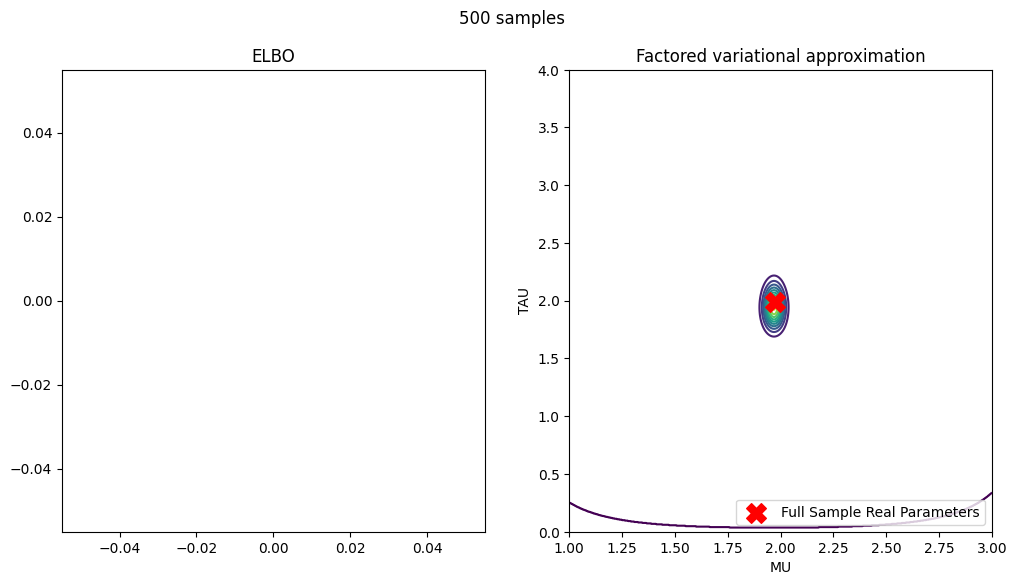

In [17]:
rng = np.random.default_rng(64852)

full_data_mu = data.mean()
full_data_tau = 1 / (data.std()**2)

for n_samples in [10, 50, 100, 500]:
    print(f'\n>>> Sample Size: {n_samples}\n')

    # Making choice of samples
    indexes = rng.choice(data.shape[0], size=n_samples, replace=False)
    X = data[indexes, :]

    # Sample size
    N = X.shape[0]

    # Initializing priori parameters
    mu_0 = 0
    k_0 = 1
    a_0 = 1
    b_0 = 1

    # Optimal values for mu_n and a_n
    mu_n = (k_0 * mu_0 + X.sum()) / (k_0 + N)
    a_n = a_0 + ((N + 1) / 2)
    
    # Initializing b_n and k_n
    b_n = 1
    k_n = 1

    # Iteration
    arr_elbo = []
    for i in range(10):
        k_n = (k_0 + N) * (a_n / b_n)
        first_term =  b_0 + (k_0 / 2) * (1/k_n + (mu_n - mu_0)**2)
        second_term = np.sum((1/k_n) + (X - mu_n)**2) / 2
        b_n = first_term + second_term

        arr_elbo.append(ELBO(k_n, a_n, b_n))

    # Defining posteriori distributions
    # The scipy's scale parameter is 1/b
    tau_dist = gamma(a=a_n, scale=1/b_n) # scale parameter is 1/b
    # The scipy's scale parameter is the standard deviation
    mu_dist = norm(loc=mu_n, scale=1/np.sqrt(k_n)) 
    
    # Show results
    dim = 1000
    mu_list = np.linspace(1, 3, dim)
    tau_list = np.linspace(0, 4, dim)

    mu_list, tau_list = np.meshgrid(mu_list, tau_list)
    mu_list, tau_list = mu_list.flatten(), tau_list.flatten()

    # Factored variational approximation
    Z = mu_dist.pdf(mu_list) * tau_dist.pdf(tau_list)

    mu_list = mu_list.reshape(dim, dim)
    tau_list = tau_list.reshape(dim, dim)
    Z = Z.reshape(dim, dim)
    
    print('\nEXPECTED MU:', mu_dist.mean())
    print('EXPECTED TAU:', tau_dist.mean(), '\n')

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].set_title('ELBO')
    ax[0].plot(arr_elbo)

    ax[1].set_title(f'Factored variational approximation')
    ax[1].contour(mu_list, tau_list, Z, levels=10)
    ax[1].scatter(
        full_data_mu, full_data_tau, s=200, c='r', marker='X',
        label='Full Sample Real Parameters',
        zorder=100
    )
    
    ax[1].set_xlabel('MU')
    ax[1].set_ylabel('TAU')
    ax[1].legend(loc='lower right')

    plt.suptitle(f'{n_samples} samples')
    plt.show()
